# Challenge
O problema consiste em montar um modelo de machine learning que preveja qual nota um filme receberia caso fosse colocado no catálogo.  
Não se preocupe muito com a precisão final do modelo.  
Os ítens que serão avaliados individualmente são os seguintes:

- Tratamento dos dados.
- Feature engeneering.
- Divisão da base de dados entre dataset teste e dataset treino.
- A Matriz de Confusão do seu modelo de testes assim como o gráfico de precision e recall do seu modelo
- Tendo em vista o resultado final o que você faria para melhorar o modelo?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1)

## Data processing

In [2]:
# Target = 'rating'
df = pd.read_excel('dataset_netflix.xlsx', engine='openpyxl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6234 non-null   int64         
 1   type          6234 non-null   object        
 2   title         6234 non-null   object        
 3   director      4264 non-null   object        
 4   cast          6233 non-null   object        
 5   country       6233 non-null   object        
 6   date_added    6222 non-null   datetime64[ns]
 7   release_year  6233 non-null   float64       
 8   rating        6233 non-null   float64       
 9   duration      6233 non-null   object        
 10  listed_in     6233 non-null   object        
 11  description   6233 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 584.6+ KB


In [4]:
df['director'] = df.director.fillna(value='Unknow')

In [5]:
df['type'] = df.type.astype('category')
df['director'] = df.director.str.split(',')
df['cast'] = df.cast.str.split(',')
df['country'] = df.country.str.split(',')
df['duration'] = df.duration.str.split(' ')
df['listed_in'] = df.listed_in.str.split(',')
df['date_added_month'] = df.date_added.dt.month
df['date_added_year'] = df.date_added.dt.year

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().values.any()

False

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6222 entries, 0 to 6222
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   show_id           6222 non-null   int64         
 1   type              6222 non-null   category      
 2   title             6222 non-null   object        
 3   director          6222 non-null   object        
 4   cast              6222 non-null   object        
 5   country           6222 non-null   object        
 6   date_added        6222 non-null   datetime64[ns]
 7   release_year      6222 non-null   float64       
 8   rating            6222 non-null   float64       
 9   duration          6222 non-null   object        
 10  listed_in         6222 non-null   object        
 11  description       6222 non-null   object        
 12  date_added_month  6222 non-null   float64       
 13  date_added_year   6222 non-null   float64       
dtypes: category(1), datetime

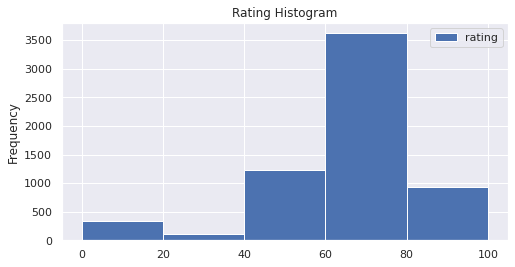

In [9]:
df[['rating']].plot(kind='hist', title='Rating Histogram', figsize=(8,4), align='mid', bins=range(0, 101, 20));

## Exploring & Feature Engeneering

In [10]:
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
df1 = df.copy()

### Classes
The model will try to predict if the rating will be in the interval classes below:

0. [0, 20)
1. [20, 40)
2. [40, 60)
3. [60, 80)
4. [80, 100)

In [12]:
bins = list(range(0, 101, 20))
bins

[0, 20, 40, 60, 80, 100]

In [13]:
# Create new target to classify 
for i, value in df['rating'].iteritems():
    for n, (i1, i2) in enumerate(zip(bins, bins[1:])):
        if (value >= i1) & (value < i2):
            df1.loc[i, 'rating_class'] = n

In [14]:
def count_list_df(df, column: str) -> list:
    return [len(x) for x in df[column].values]

def minutes_or_season(duration: pd.Series) -> list:
    return ['minutes' if x[1].lower() in ['min', 'mins'] else 'season' if x[1].lower() in ['season', 'seasons'] else None for x in duration.values]

def duration_(duration: pd.Series) -> list:
    return [x[0] for x in duration.values]

In [15]:
df1['directors'] = count_list_df(df1, 'director')
df1['cast_amount'] = count_list_df(df1, 'cast')
df1['listed_in_amount'] = count_list_df(df1, 'listed_in')
df1['countries'] = count_list_df(df1, 'country')
df1['duration_amount'] = duration_(df1.duration)
df1['diff_added_release'] = df1.date_added.dt.year - df1.release_year

In [16]:
for i, cast_list in df1.cast.items():
    df1.at[i, 'cast'] = [actor.lower().lstrip(' ') for actor in cast_list]

for i, country in df1.country.items():
    df1.at[i, 'country'] = [c.lower().lstrip(' ') for c in country]

for i, genre in df1.listed_in.items():
    df1.at[i, 'listed_in'] = [g.lower().lstrip(' ').replace("'", "") for g in genre]

In [17]:
df1[['title_f1', 'title_f2', 'title_f3']] = TfidfVectorizer(stop_words='english', max_features=3).fit_transform(df1.title).toarray()
df1[['description_f1', 'description_f2', 'description_f3']] = TfidfVectorizer(stop_words='english', max_features=3).fit_transform(df1.description).toarray()

In [18]:
df1['duration'] = df1.duration_amount.astype(int)
df1.loc[df1.type == 'Movie', 'movie_minutes'] = df1.loc[df1.type == 'Movie'].duration_amount.values
df1.loc[df1.type == 'TV Show', 'serie_seasons'] = df1.loc[df1.type == 'TV Show'].duration_amount.values
df1.movie_minutes.fillna(0, inplace=True)
df1.serie_seasons.fillna(0, inplace=True)

In [19]:
all_movies_cast = []
for cast_list in df1.cast:
    for actor in cast_list:
        all_movies_cast.append(actor)

In [20]:
print('Most common actors')
pd.Series(all_movies_cast).value_counts()[:10]

Most common actors


bam                 568
anupam kher          33
shah rukh khan       30
om puri              27
naseeruddin shah     27
yuki kaji            26
akshay kumar         26
takahiro sakurai     25
paresh rawal         25
amitabh bachchan     24
dtype: int64

In [21]:
all_countries = []
for countries_list in df1.country:
    for c in countries_list:
        if c == 'none':
            all_countries.append(None)
        else:
            all_countries.append(c)

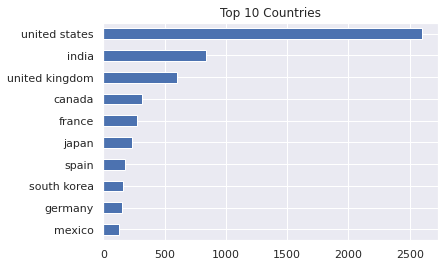

In [22]:
pd.Series(all_countries).value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Countries');
top_10_countries = pd.Series(all_countries).value_counts()[:10].index.tolist()

In [23]:
all_genre_list = []
for genre_list in df1.listed_in:
    for genre in genre_list:
        all_genre_list.append(genre)
# all_genre_list

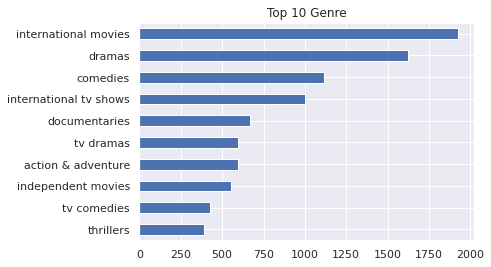

In [24]:
pd.Series(all_genre_list).value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Genre');
top_10_genre = pd.Series(all_genre_list).value_counts()[:10].index.tolist()

---

In [25]:
df2 = df1.copy()

In [26]:
df2['type'] = LabelEncoder().fit_transform(df2.type)

In [27]:
df2['release_year'] = MinMaxScaler().fit_transform(df2[['release_year']])
df2['date_added_year'] = MinMaxScaler().fit_transform(df2[['date_added_year']])

In [28]:
top_10_countries.reverse()
top_10_countries

['mexico',
 'germany',
 'south korea',
 'spain',
 'japan',
 'france',
 'canada',
 'united kingdom',
 'india',
 'united states']

In [29]:
weights = (pd.Series(all_countries).value_counts()[:10]/pd.Series(all_countries).value_counts()[:10].max()).tolist()
weights.reverse()
weights

[0.04955820207452939,
 0.058009988474836724,
 0.0622358816749904,
 0.06838263542066846,
 0.08835958509412217,
 0.10411064156742221,
 0.12216673069535151,
 0.23088743757203228,
 0.3219362274298886,
 1.0]

In [30]:
rank_list = []
df2[top_10_countries] = 0

for i, countries_list in df2['country'].iteritems():
    rank_scale = 0
    for country in countries_list:
        for w, c in zip(weights, top_10_countries):
            if country == c:
                rank_scale += w
                df2.loc[i, c] = 1
    rank_list.append(rank_scale)

df2['country_rank'] = rank_list

In [31]:
df2[top_10_genre] = 0
for i, genre_list in df2['listed_in'].iteritems():
    for genre in genre_list:
        for g in top_10_genre:
            if genre == g:
                df2.loc[i, g] = 1

In [32]:
predictors = ['type', 'release_year', 'date_added_month', 'date_added_year', 'directors',
       'cast_amount', 'listed_in_amount', 'countries',
       'diff_added_release', 'movie_minutes', 'serie_seasons', 'title_f1',
       'title_f2', 'title_f3', 'description_f1', 'description_f2',
       'description_f3', 'mexico', 'germany', 'south korea', 'spain', 'japan',
       'france', 'canada', 'united kingdom', 'india', 'united states',
       'country_rank', 'international movies', 'dramas', 'comedies',
       'international tv shows', 'documentaries', 'tv dramas',
       'action & adventure', 'independent movies', 'tv comedies', 'thrillers']

target = ['rating_class']


In [33]:
df2.reset_index(inplace=True)

In [34]:
df3 = pd.DataFrame(Normalizer().fit_transform(df2[predictors]), columns=predictors)
df3 = pd.DataFrame(StandardScaler().fit_transform(df3), columns=predictors)
df3[target] = df2[target]

In [35]:
df3.head()

,type,release_year,date_added_month,date_added_year,directors,cast_amount,listed_in_amount,countries,diff_added_release,movie_minutes,...,dramas,comedies,international tv shows,documentaries,tv dramas,action & adventure,independent movies,tv comedies,thrillers,rating_class
0,-0.598389,-0.559009,-0.480273,-0.539940,-0.346257,-0.409132,-0.557693,0.047365,-0.548980,0.682930,...,-0.5615,2.225088,-0.404688,-0.30931,-0.30881,-0.317668,-0.299331,-0.254238,-0.255822,2.0
1,-0.598389,-0.575901,-0.492814,-0.620685,-0.596124,-0.774431,-0.666463,-0.588047,-0.548980,0.700326,...,-0.5615,-0.438329,-0.404688,-0.30931,-0.30881,-0.317668,-0.299331,-0.254238,-0.255822,2.0
2,0.707255,0.549895,1.201522,0.585590,0.539945,1.937652,-0.171922,0.397058,1.396557,-1.472105,...,-0.5615,-0.438329,-0.404688,-0.30931,-0.30881,-0.317668,-0.299331,-0.254238,-0.255822,4.0
3,1.068594,0.987487,1.766622,0.972055,0.918851,1.528198,-0.006981,0.725614,0.444607,-1.472105,...,-0.5615,-0.438329,-0.404688,-0.30931,-0.30881,-0.317668,-0.299331,-0.254238,-0.255822,3.0
4,-0.598389,-0.587103,-0.512605,-0.609096,-0.609394,-0.371828,-0.672239,-0.599554,-0.548980,0.685603,...,-0.5615,1.985963,-0.404688,-0.30931,-0.30881,-0.317668,-0.299331,-0.254238,-0.255822,2.0


## Model

In [36]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
df3[predictors], df3[target], test_size=0.3, random_state=42)

In [38]:
# Data IMPUTATION to balance all classes
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

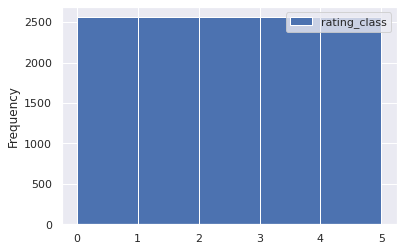

In [39]:
y_train.plot(kind='hist', bins=range(6));

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, classification_report

from yellowbrick.classifier import PrecisionRecallCurve

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [41]:
classifiers = [
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=3),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
    ]

In [42]:
trained_classifier = dict()
for model in classifiers:
    mod = model.fit(X_train, y_train)
    scores = cross_val_score(mod, X_train, y_train, cv=10)
    y_score = mod.predict(X_test)
    trained_classifier[type(mod).__name__] = {'model': mod,
                                              'scores': scores,
                                              'classification_report': classification_report(y_test, y_score, digits=3)}

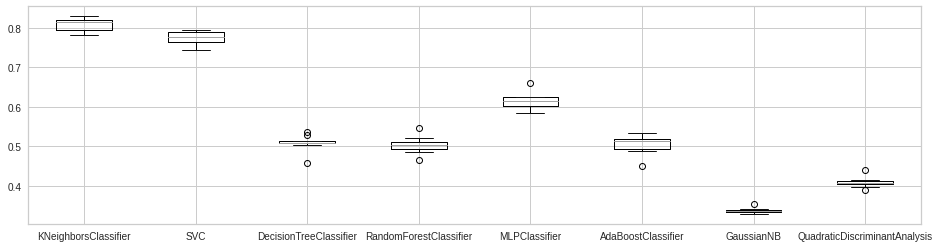

In [43]:
scores_df = pd.DataFrame()
for classifier in trained_classifier:
    scores_df[classifier] = trained_classifier[classifier]['scores']

scores_df.boxplot(figsize=(16,4));

In [44]:
print(trained_classifier['KNeighborsClassifier']['classification_report'])

              precision    recall  f1-score   support

         0.0      0.221     0.431     0.292       109
         1.0      0.062     0.139     0.085        36
         2.0      0.309     0.469     0.373       373
         3.0      0.643     0.391     0.487      1061
         4.0      0.296     0.372     0.329       288

    accuracy                          0.401      1867
   macro avg      0.306     0.360     0.313      1867
weighted avg      0.487     0.401     0.420      1867



In [45]:
model = trained_classifier['KNeighborsClassifier']['model']

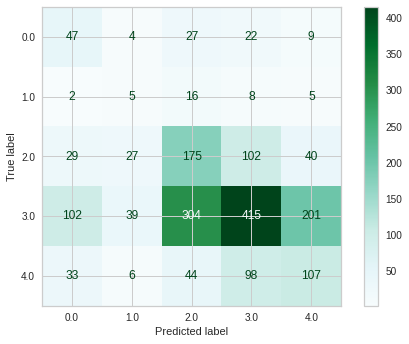

In [46]:
plot_confusion_matrix(model, X_test, y_test, cmap='BuGn');

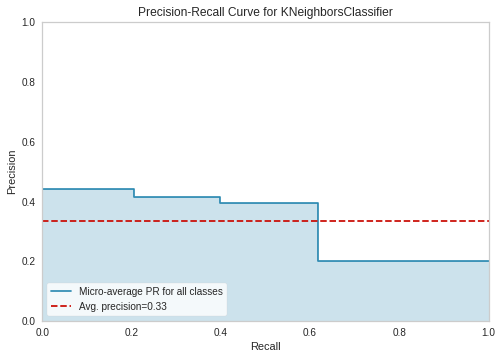

In [47]:
viz = PrecisionRecallCurve(model).fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();